# (02) HRF -- plot

**Motivation**: Plot HRF results for ca2 data. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def default_props_anesth(
        num_k: int = 7,
        perc: int = 15,
        **kwargs, ):
    mice = Mice(512)
    props_base = {
        'mice': mice,
        'num_k': num_k,
        'task': 'rest',
        'perc': f'p{perc}-sample',
        'metric': 'pearson',
        'sv_props': {
            'match_using': 'gam',
            'match_metric': 'euclidean'},
        'graph_type': 'real',
        'kw_kmeans': {'n_init': 100},
        'verbose': False,
    }
    kwargs = setup_kwargs(props_base, kwargs)
    props_ca = {'mode': 'ca2', **kwargs}
    return mice, props_ca


def get_results(desc):
    bands = {
        (0.01, 0.5): CAS,
        (0.5, 5.0): CAF,
    }
    results = {}
    for b in bands:
        mice.set_kws(band_ca2=b, desc_ca2=desc, task='rest')
        gr = Group(mice=mice, mode='ca2', perc='p15-sample', num_k=7)
        results[bands[b]] = gr.avg(ndim_start=1)
    if desc == 'preproc':
        gr = Group(mice=mice, mode='bold-lite', perc='p15-sample', num_k=8)
        pi_mrg, _ = gr.merge_vis(0.444, gr.run_pi)
        results['BOLD'] = gr.avg(pi_mrg, ndim_start=1)
    results_avg = {
        k: avg(v) for k, v
        in results.items()
    }

    src_key = (0.01, 0.5)
    src_key = bands[src_key]
    global_order = 'infer'
    match_metric = 'correlation'
    if desc == 'hrf':
        final_perm = {4: 5, 5: 4}
    elif desc == 'preproc':
        final_perm = {4: 5, 5: 6, 6: 4}
    else:
        raise ValueError(desc)
    final_perm = {
        i: final_perm.get(i, i) for
        i in range(props['num_k'])
    }

    gmap = find_best_mappings(
        data=results_avg,
        centroids=results_avg[src_key],
        match_metric=match_metric,
        global_order=global_order[0],
    )
    if final_perm:
        for k, v in gmap.items():
            gmap[k] = {
                s: v[t] for s, t in
                final_perm.items()
            }
        gmap = {
            k: gmap.get(k, final_perm)
            for k in results_avg
        }

    if desc == 'preproc':
        # CAF
        _perm = {3: 5, 5: 3}
        _perm = {
            i: _perm.get(i, i) for
            i in range(props['num_k'])
        }
        k = next(
            k for k in gmap if
            k == bands[(0.5, 5.0)]
        )
        gmap[k] = {
            s: gmap[k][t] for
            s, t in _perm.items()
        }
        # BOLD
        _perm = {3: 6, 6: 3}
        _perm = {
            i: _perm.get(i, i) for
            i in range(props['num_k'])
        }
        k = next(
            k for k in gmap
            if k == 'BOLD'
        )
        gmap[k] = {
            s: gmap[k][t] for
            s, t in _perm.items()
        }
        
    # now load results again, keep at run level
    results = {}
    for b in bands:
        mice.set_kws(band_ca2=b, desc_ca2=desc, task='rest')
        gr = Group(mice=mice, mode='ca2', perc='p15-sample', num_k=7)
        results[bands[b]] = bn.nanmean(gr.run_pi, -3)
    if desc == 'preproc':
        gr = Group(mice=mice, mode='bold-lite', perc='p15-sample', num_k=8)
        pi_mrg, _ = gr.merge_vis(0.444, gr.run_pi)
        results['BOLD'] = bn.nanmean(pi_mrg, -3)

    # get pi
    pi_run = {
        k: v[..., list(gmap[k].values()), :]
        for k, v in results.items()
    }
    pi_run = {
        f"{desc}\n{k}": v for
        k, v in pi_run.items()
    }
    pi_grp = {
        k: avg(v) for k, v
        in pi_run.items()
    }
    return pi_run, pi_grp

## Mice

In [3]:
mice, props = default_props_anesth()
kws_show = show_kws(props['num_k'])
bs = Base(mice, mode='ca2')

fig_dir = pjoin(fig_base_dir, 'rebuttal')
print(fig_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal

## Get results

In [4]:
pi_hrf_run, pi_hrf_grp = get_results('hrf')
pi_preproc_run, pi_preproc_grp = get_results('preproc')

pi_run = {**pi_preproc_run, **pi_hrf_run}
pi_grp = {**pi_preproc_grp, **pi_hrf_grp}

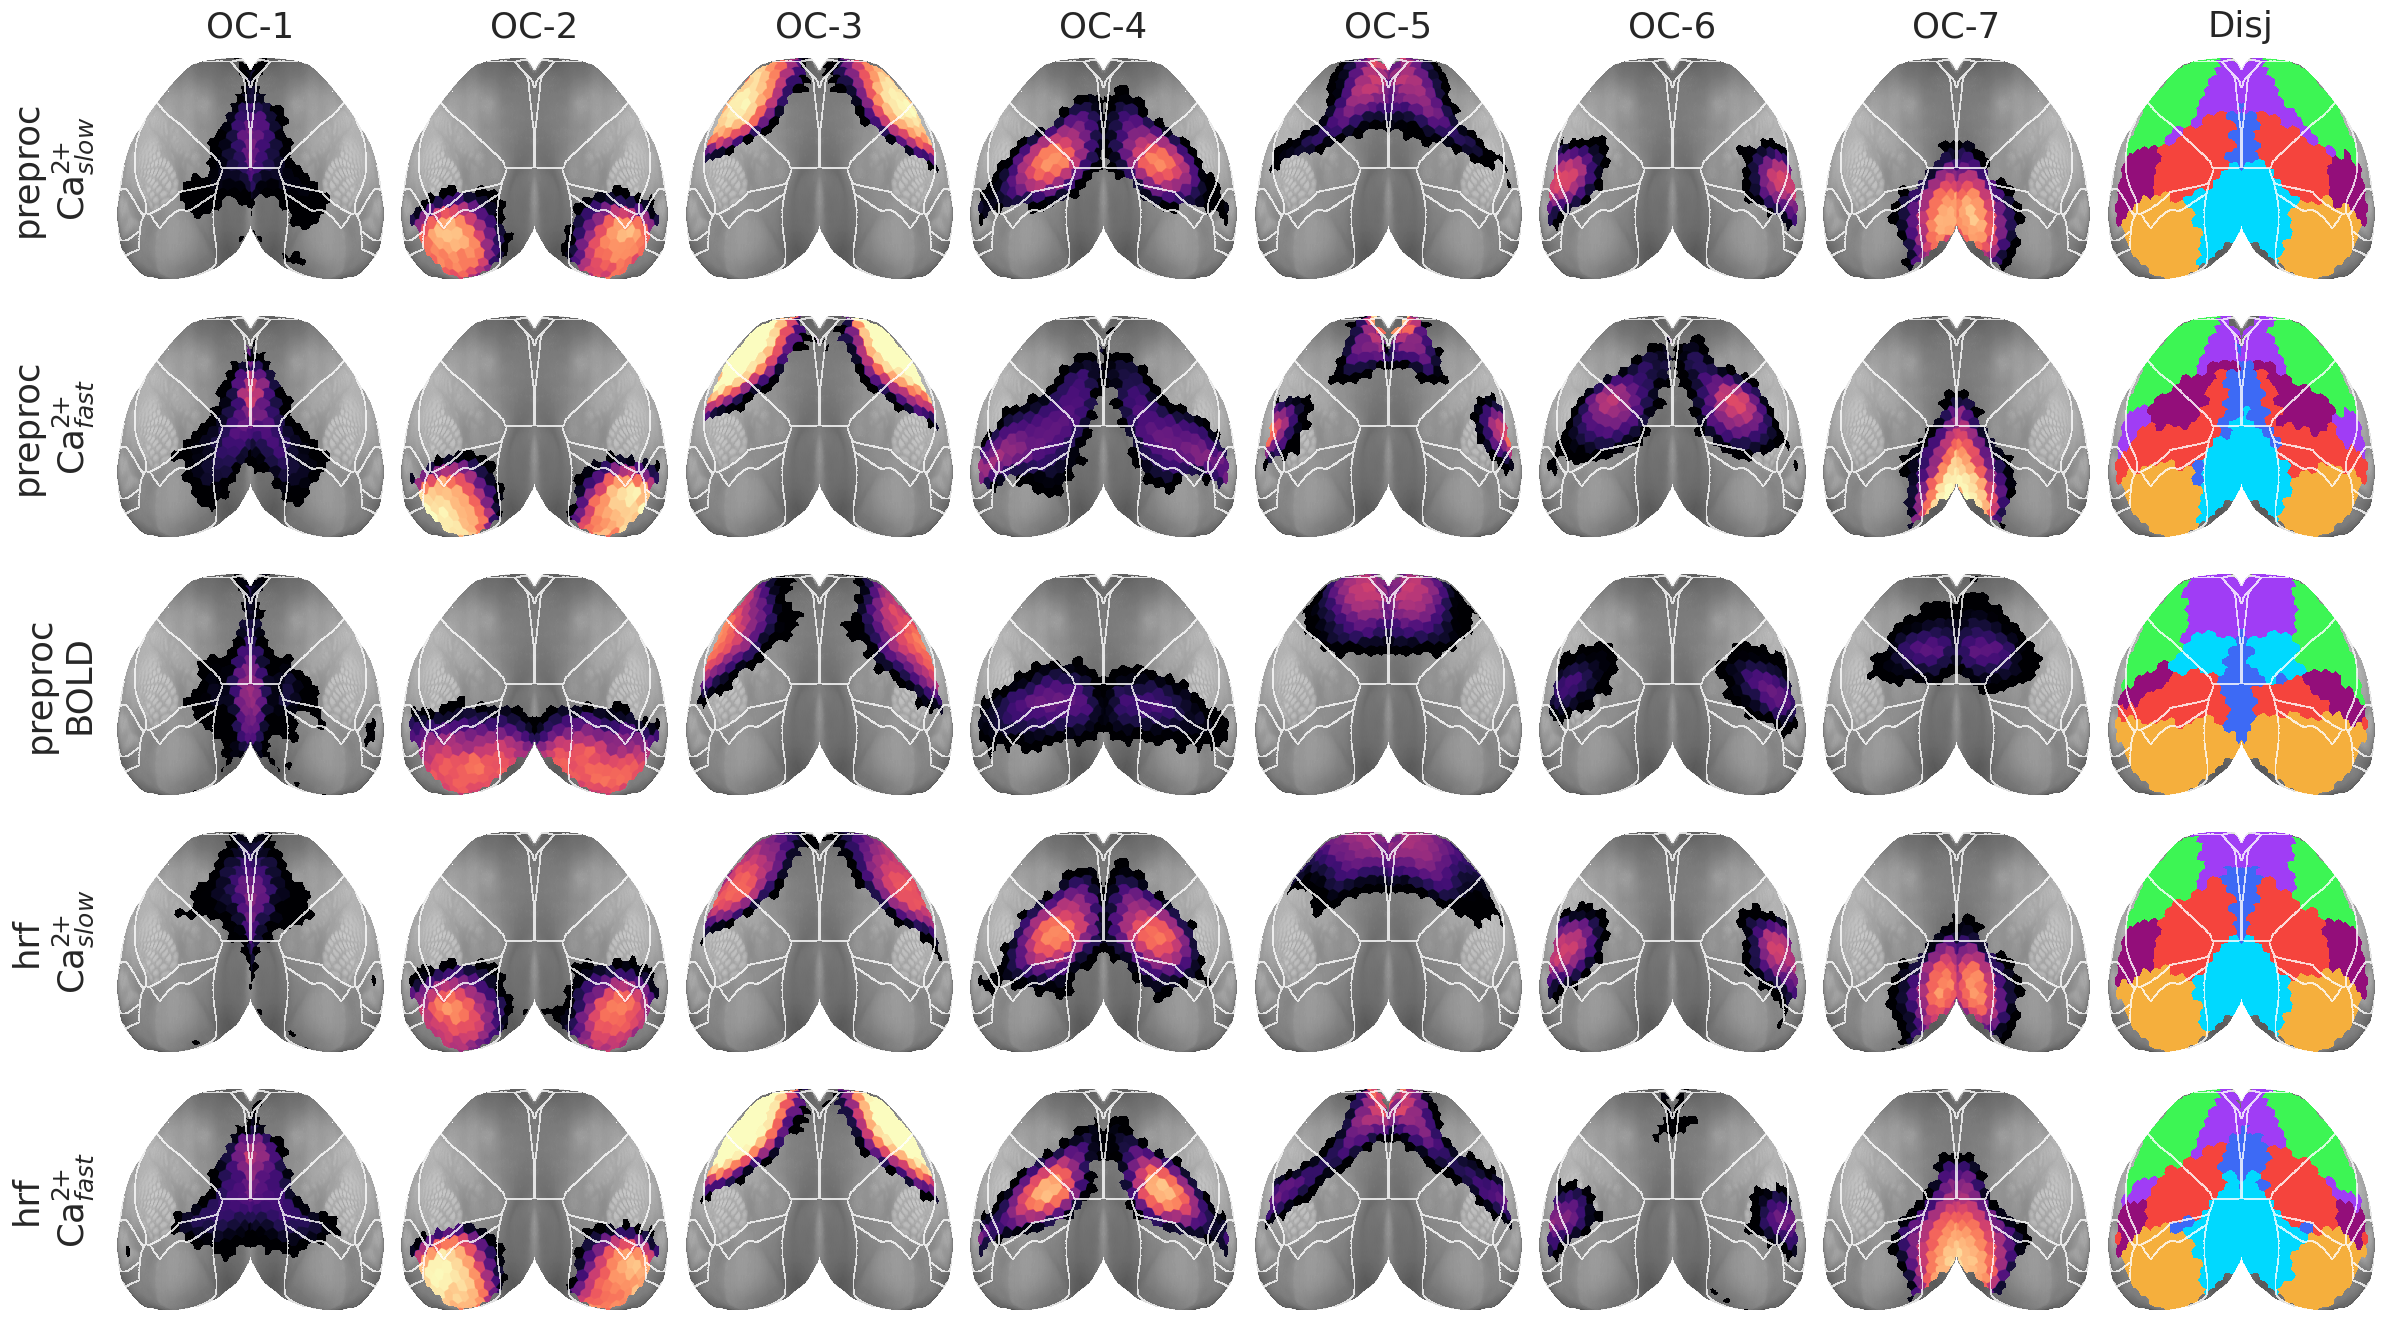

In [5]:
fig, axes = bs.show(pi_grp, **kws_show)

In [6]:
_ = save_obj(
    obj=pi_run,
    file_name='pi_run',
    save_dir=tmp_dir,
    mode='npy',
)
_ = save_obj(
    obj=pi_grp,
    file_name='pi_grp',
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'pi_run.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'pi_grp.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

## Cosine sim

In [6]:
sim, sim_overall = cosine_sim(pi)

In [7]:
t = PrettyTable()
t.field_names = ['# 1', '# 2', 'Overall'] + [f"OC-{i+1}" for i in range(7)]
for c1, c2 in itertools.combinations(pi, 2):
    vals = [
        str(c1).replace('\n', ' ').replace(CAS, 'CAS').replace(CAF, 'CAF').replace('preproc ', ''),
        str(c2).replace('\n', ' ').replace(CAS, 'CAS').replace(CAF, 'CAF').replace('preproc ', ''),
        f"{sim_overall[(c1, c2)].mean(0):0.4f}",
    ] + [f"{e:0.3f}" for e in np.diagonal(sim[(c1, c2)].mean(0))]
    t.add_row(vals)

In [8]:
print(t)

+---------+---------+---------+-------+-------+-------+-------+-------+-------+-------+
|   # 1   |   # 2   | Overall |  OC-1 |  OC-2 |  OC-3 |  OC-4 |  OC-5 |  OC-6 |  OC-7 |
+---------+---------+---------+-------+-------+-------+-------+-------+-------+-------+
|   CAS   |   CAF   |  0.8807 | 0.897 | 0.953 | 0.976 | 0.843 | 0.704 | 0.511 | 0.943 |
|   CAS   |   BOLD  |  0.7564 | 0.828 | 0.855 | 0.887 | 0.693 | 0.881 | 0.830 | 0.286 |
|   CAS   | hrf CAS |  0.9365 | 0.858 | 0.966 | 0.966 | 0.968 | 0.858 | 0.965 | 0.973 |
|   CAS   | hrf CAF |  0.9459 | 0.904 | 0.969 | 0.987 | 0.938 | 0.890 | 0.848 | 0.964 |
|   CAF   |   BOLD  |  0.7074 | 0.801 | 0.820 | 0.867 | 0.790 | 0.590 | 0.694 | 0.253 |
|   CAF   | hrf CAS |  0.8121 | 0.729 | 0.914 | 0.945 | 0.821 | 0.585 | 0.524 | 0.898 |
|   CAF   | hrf CAF |  0.9072 | 0.935 | 0.978 | 0.984 | 0.805 | 0.850 | 0.498 | 0.960 |
|   BOLD  | hrf CAS |  0.7593 | 0.740 | 0.864 | 0.903 | 0.734 | 0.909 | 0.844 | 0.306 |
|   BOLD  | hrf CAF |  0.7244 | 0.810 | 0.837 | 0.880 | 0.609 | 0.754 | 0.757 | 0.316 |
| hrf CAS | hrf CAF |  0.8663 | 0.754 | 0.927 | 0.954 | 0.877 | 0.731 | 0.813 | 0.926 |
+---------+---------+---------+-------+-------+-------+-------+-------+-------+-------+

## Save fig

In [9]:
kws_show['label_fontsize'] = 8
kws_show['figsize_x'] = 2.8
kws_show['figsize_y'] = 1.0
kws_show['display'] = False

kws_show

{
    'vmin': 0.2,
    'vmax': 0.9,
    'mask_thresh': 0.14285714285714285,
    'label_fontsize': 8,
    'add_disjoint': True,
    'titles': True,
    'figsize_x': 2.8,
    'figsize_y': 1.0,
    'display': False
}

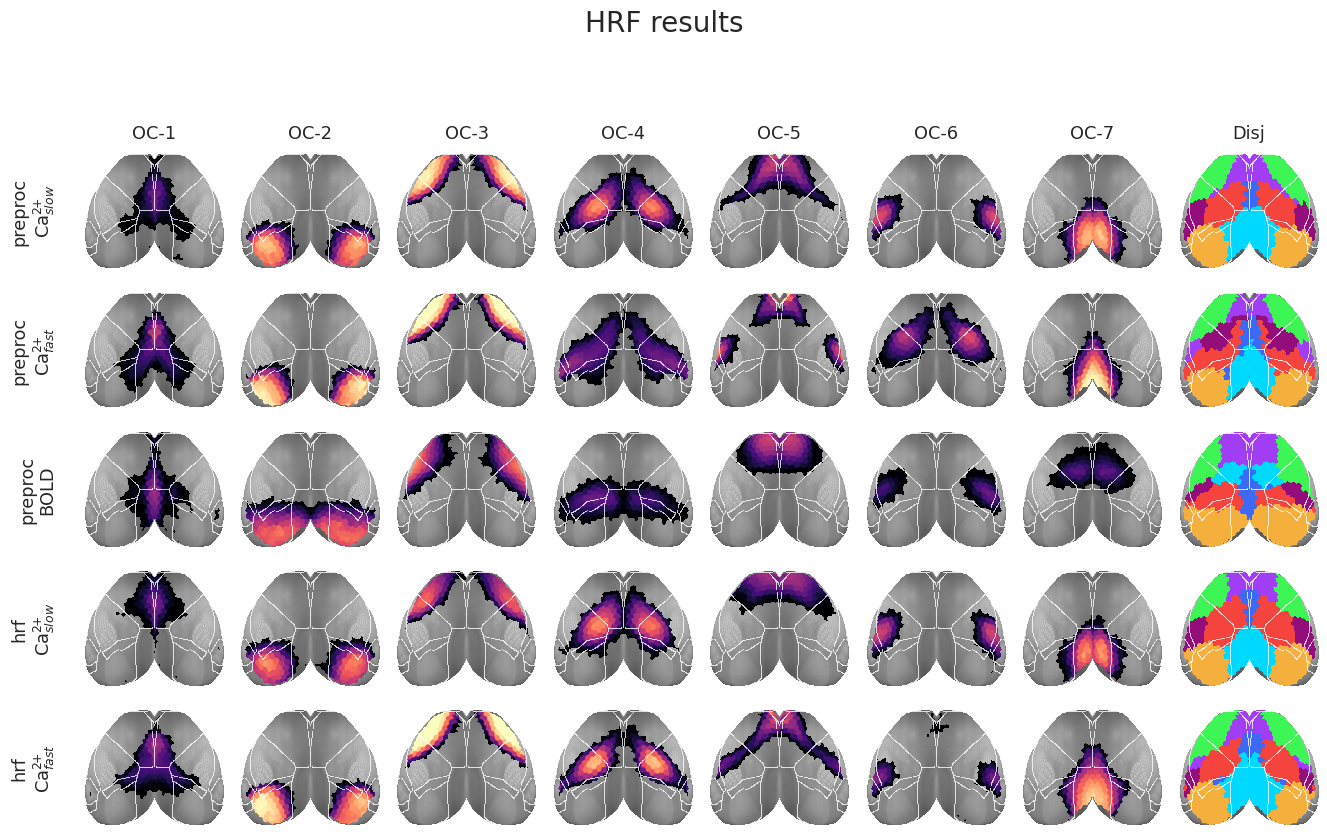

In [10]:
f, axes = bs.show(pi_avg, **kws_show)
s = f.suptitle('HRF results', fontsize=20, y=1.06)
f.savefig(
    pjoin(fig_dir, f"anesth_ca2_hrf.png"),
    bbox_extra_artists=[s],
    bbox_inches='tight',
    dpi=200,
)
display(f)